In [ ]:
%load_ext autoreload

%autoreload 2

import os

os.chdir("../")

In [ ]:
"""
Code by Parthe Pandit and Arunav Gupta
DSC 180 Capstone
Advisor: Mikhail Belkin
"""
from typing import Tuple, Union
import numpy as np, math
import nltk

n, noise_std, gamma, p, lam = 50, 0.1, 10, 8, 1e-8


def target_poly(x):
    return x**5 - 3 * x**4


target_xsinx = lambda x: x * np.sin(x)
# def target_xsinx(x):
#     return x * np.sin(x)


def K_gauss(x, z, gamma=gamma):
    return np.exp(-np.linalg.norm(x - z) ** 2 * gamma / 2)


def K_gauss_mat(x, z, gamma=gamma):
    return np.exp(
        -np.linalg.norm(x[:, None, :] - z[None, :, :], axis=-1) ** 2 * gamma / 2
    )


# K_gauss = lambda x, z, gamma=gamma: np.exp(-np.linalg.norm(x-z)**2 * gamma/2)

K_poly = lambda x, z, gamma=gamma, p=p: (1 + np.sum(x * z) / gamma) ** p


def K_poly_mat(x, z, gamma=gamma, p=p):
    """
    if x is (m, d) and z is (n, d)
    then output is (m, n)
    """
    return (1 + np.sum(x[:, None, :] * z[None, :, :], axis=-1) / gamma) ** p


Phi_poly = lambda X, p: np.hstack([X**i for i in range(p + 1)])

Phi_poly_scaled = lambda X, p, gamma=gamma: (
    Phi_poly(X, p)
    * np.array([np.sqrt(math.comb(p, i) / gamma**i) for i in range(p + 1)])
)

K_laplace = lambda x, z, gamma=gamma: np.exp(-np.linalg.norm(x - z, axis=-1) * gamma)


def K_laplace_mat(x, z, gamma=gamma):
    return np.exp(
        -np.linalg.norm(x[:, None, :] - z[None, :, :], ord=1, axis=-1) * gamma
    )


# RFM utils


def mnorm(x, z, M, power=1, squared=True):  # (n, d), (m,d), (d,d) --> (n, m)
    M_alt = M**power
    # implements |x-z|_M^2 between pairs from x and z
    x_norm = ((x @ M_alt) * x).sum(axis=1, keepdims=True)
    if x is z:
        z_norm = x_norm
    else:
        z_norm = ((z @ M_alt) * z).sum(axis=1, keepdims=True)

    z_norm = z_norm.reshape(1, -1)

    distances = (x @ (M_alt @ z.T) * -2) + x_norm + z_norm
    if not squared:
        distances = np.sqrt(np.clip(distances, 0, np.inf))
    return distances


def K_M(x, z, M, L, power=1):
    pairwise_distances = mnorm(x, z, M, power, squared=False)
    pairwise_distances = np.clip(pairwise_distances, 0, np.inf)
    return np.exp(pairwise_distances * -(1.0 / L))


def grad_laplace_mat(X, sol, L, P, power=1, batch_size=2, norm_control=False):
    M = 0.0

    num_samples = 20000
    indices = np.random.randint(len(X), size=num_samples)

    if len(X) > len(indices):
        x = X[indices, :]
    else:
        x = X

    K = K_M(X, x, P, L, power)

    dist = mnorm(X, x, P, power, squared=False)
    dist = np.where(dist < 1e-4, np.zeros(1, dtype=np.float64), dist)

    K = K / dist
    K[K == float("inf")] = 0.0

    # sol = sol[:, None]
    a1 = sol

    n, d = X.shape
    n, c = sol.shape
    m, d = x.shape

    a1 = a1.reshape(n, c, 1)
    X1 = (X @ P).reshape(n, 1, d)
    step1 = a1 @ X1
    del a1, X1
    step1 = step1.reshape(-1, c * d)

    step2 = K.T @ step1
    del step1

    step2 = step2.reshape(-1, c, d)

    a2 = sol.T
    step3 = (a2 @ K).T

    del K, a2

    step3 = step3.reshape(m, c, 1)
    x1 = (x @ P).reshape(m, 1, d)
    step3 = step3 @ x1

    G = (step2 - step3) * -1 / L

    M = 0.0

    bs = batch_size
    if norm_control:
        G = rsvd_norm_control(G[:, 0, :])[:, None, :]
    batches = np.split(G, bs)
    for i in range(len(batches)):
        grad = batches[i]
        gradT = np.swapaxes(grad, 1, 2)
        M += np.sum(gradT @ grad, axis=0)
        del grad, gradT
    M /= len(G)

    return M


def rsvd_norm_control(J, keep_p=0.5):
    """
    Apply randomized svd to J and return the reconstructed matrix using the top keep_p values.
    """
    k = int(keep_p * J.shape[1])
    u, s, v = np.linalg.svd(J, full_matrices=False)
    return np.dot(u[:, :k], np.dot(np.diag(s[:k]), v[:k, :]))


"""
def grad_laplace_mat(a, x, z, M, L): # (n, d), (m, d), (d, d) --> (n, m, d)
    num_samples = 20000
    
    dist = mnorm(x, z, M, squared=False)
    dist = np.where(dist < 1e-4, np.zeros(1, dtype=np.float16), dist)
    
    K = K_M(x, z, M, L)/dist
    K[K == float('inf')] = 0.
    
    a = a[:, None]
    
    n, d = x.shape
    n, c = a.shape
    m, d = z.shape
    
    a = a.reshape(n, c, 1)
    X1 = (x @ M).reshape(n, 1, d)
    step1 = (a @ X1).reshape(-1, c*d)
    
    step2 = (K.T @ step1).reshape(-1, c, d)
    del step1
    
    step3 = ((a.T @ K).T).reshape(m, c, 1)
    z1 = (z @ M).reshape(m, 1, d)
    step3 = step3 @ z1
    
    G = (step2 - step3) * -1/L
    
    return G
"""


def mse(y_true, y_pred, squared=True):
    if squared:
        power = 2
    else:
        power = 1
    return ((y_true - y_pred) ** power).mean()


# text generation utils
def bleu_score(y_true, y_pred, n=4):
    return nltk.translate.bleu_score.sentence_bleu(y_true, y_pred, weights=(1 / n,) * n)


def entropy(y):
    """Computes the entropy of an array of numbers."""
    y = y / y.sum()
    logged = np.where(y > 0, np.log2(y + 1e-23), 0)
    return -np.sum(y * logged)


def perplexity(y):
    """Computes the 2 ^ entropy of an array of numbers."""
    return 2 ** entropy(y)


def softmax(X, axis=0):
    """
    Applies softmax acros specified axis.
    """
    e_x = np.exp(X - np.max(X, axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)

In [ ]:
from logging import Logger

import numpy as np
from sklearn.datasets import make_classification
import hashlib
import os
import requests
import json
from bs4 import BeautifulSoup

TARGET_FNS = {"xsinx": target_xsinx}


def generate_test_data(
    target_fn_id: str, n_samples: int, noise_std: float, save_path: str = None
):
    """Generates test dataset following the given target function with some noise.

    Parameters
    ----------
    target_fn_id : str
        Name of the target function to use.
    n_samples : int
        Number of samples to generate.
    noise_std : float
        Standard deviation of the noise to add to the target function.
    save : bool, optional
        Whether to save the generated data to a file, by default False.

    Returns
    -------
    np.ndarray
        Generated data of shape (n_samples, 2).
    """
    x = np.random.rand(n_samples, 1) * 10 - 5
    y = TARGET_FNS[target_fn_id](x) + np.random.randn(*x.shape) * noise_std

    data = np.hstack([x, y])
    if save_path:
        np.savetxt(save_path, data, delimiter=",")
    return data


def generate_test_classification(
    n_samples: int,
    n_features: int,
    n_classes: int,
    informative_pct: float = 1.0,
    save_path: str = None,
):
    """Generates a random classification dataset using sklearn make_classification.

    Parameters
    ----------
    n_samples : int
        Number of samples to generate.
    n_features : int
        Number of features to generate.
    n_classes : int
        Number of classes to generate.
    save_path : str, optional
        Path to save the generated data to, by default None.

    Returns
    -------
    np.ndarray
        Generated data.
    """
    informative_features = int(informative_pct * n_features)
    noise_features = max(n_features - informative_features, 0)
    x, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_classes=n_classes,
        n_informative=informative_features,
        n_redundant=0,
        n_repeated=0,
        n_clusters_per_class=1,
        random_state=0,
    )
    data = np.hstack([x, y.reshape(-1, 1)])
    if save_path:
        np.savetxt(save_path, data, delimiter=",")
    return data


def preproc_data(
    x_train,
    y_train,
    x_test,
    y_test,
    subset: float,
    pos_class: int,
    neg_class: int,
    logger: Logger,
):
    """Helper function to filter -> subset -> binarize data.

    Parameters
    ----------
    x_train : np.ndarray
        Training data.
    y_train : np.ndarray
        Training labels.
    x_test : np.ndarray
        Test data.
    y_test : np.ndarray
        Test labels.
    subset : float
        Fraction of the dataset to use.
    pos_class : int
        Positive class to use.
    neg_class : int
        Negative class to use.
    logger : Logger
        Logger to use.

    Returns
    -------
    Preprocessed dataset.
    """
    # Reshape the data and rescale
    x_train = x_train.reshape(x_train.shape[0], -1).astype(float) / 255.0
    x_test = x_test.reshape(x_test.shape[0], -1).astype(float) / 255.0

    # Filter the data
    train_idxs = ((y_train == pos_class) | (y_train == neg_class)).flatten()
    test_idxs = ((y_test == pos_class) | (y_test == neg_class)).flatten()
    x_train = x_train[train_idxs]
    y_train = y_train[train_idxs]
    x_test = x_test[test_idxs]
    y_test = y_test[test_idxs]

    # Subset the data
    n_train = int(x_train.shape[0] * subset)
    n_test = int(x_test.shape[0] * subset)
    logger.debug("Using %d training samples and %d test samples", n_train, n_test)
    x_train = x_train[:n_train]
    y_train = y_train[:n_train]
    x_test = x_test[:n_test]
    y_test = y_test[:n_test]

    # Change to signed ints
    y_train = y_train.astype(np.int8)
    y_test = y_test.astype(np.int8)

    # Convert to binary labels
    y_train[y_train == pos_class] = 1
    y_train[y_train == neg_class] = -1
    y_test[y_test == pos_class] = 1
    y_test[y_test == neg_class] = -1

    logger.debug("x_train shape: %s", x_train.shape)
    logger.debug("y_train shape: %s", y_train.shape)

    return (x_train, y_train), (x_test, y_test)


def load_data(dataset: str, logger: Logger, **kwargs):
    """Loads the given dataset.

    Parameters
    ----------
    dataset : str
        Name of the dataset to load.
    logger : Logger
        Logger to use.

    Returns
    -------
    np.ndarray
        Loaded dataset.
    """
    import tensorflow as tf

    DATASETS = {
        "mnist": tf.keras.datasets.mnist,
        "cifar10": tf.keras.datasets.cifar10,
        "fashionmnist": tf.keras.datasets.fashion_mnist,
    }
    if dataset in DATASETS:
        (x_train, y_train), (x_test, y_test) = DATASETS[dataset].load_data()
    else:
        raise ValueError("Unknown dataset: {}".format(dataset))
    return preproc_data(
        x_train,
        y_train,
        x_test,
        y_test,
        kwargs["subset"],
        kwargs["pos_class"],
        kwargs["neg_class"],
        logger,
    )


def make_dataset(url: str, download: bool = True):
    if "data" not in os.listdir():
        os.makedirs("data")

    hval = str(hashlib.sha256(url.encode()).hexdigest())

    if "download_log" in os.listdir():
        with open("download_log", "r") as file:
            if str(hval) in file.readlines():
                print(f"Dataset already downloaded: download_log -> {hval}")
                return False
    else:
        with open("download_log", "w") as file:
            file.write(hval)

    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
    else:
        print("Failed to retrieve data from website")

    res = [
        i.text.strip().replace("\n", "").replace("\r", "") for i in soup.find_all("p")
    ]

    fname = res[1] + ".txt"

    res = "\n".join(res)

    with open(os.path.join("data/", fname), "w") as file:
        file.write(res)

    print("Dataset successfully downloaded")
    return True


def build_vocab():
    # lowercase
    alphabet_dict = {chr(i + 97): i + 1 for i in range(26)}
    alphabet_dict.update({chr(i + 65): i + 27 for i in range(26)})

    special_characters = [".", ",", "!", "?", "'", ":", ";", "-", "_"]
    special_characters_dict = {
        char: i + 53 for i, char in enumerate(special_characters)
    }
    alphabet_dict.update(special_characters_dict)

    alphabet_dict[" "] = 0
    alphabet_dict["[PAD]"] = 62
    alphabet_dict["[UNK]"] = 63

    return alphabet_dict


def tokenizer(fp: str, contextsize: int = 32):
    vocab = build_vocab()

    with open(fp) as file:
        data = file.readlines()

    res = np.array([])

    for i in data:
        if not i:
            continue

        context = np.array([np.array([0] * len(vocab))] * contextsize)

        for j in range(contextsize):
            if j >= len(i):
                context[j][int(vocab["[PAD]"])] = 1

            elif i[j] in vocab:
                context[j][int(vocab[i[j]])] = 1

            else:
                context[j][int(vocab["[UNK]"])] = 1

        res = np.append(res, context)

    res = res.reshape(len(data), contextsize, len(vocab))

    return res, vocab


In [ ]:
import logging
import numpy as np
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)


class RFM:
    def __init__(self, L=1.0, lam=1e-3, T=10, power=1):
        self.L = L
        self.lam = lam
        self.T = T
        self.power = power

    def fit(
        self,
        X_train,
        y_train,
        X_val=None,
        y_val=None,
        L=None,
        lam=None,
        T=None,
        power=None,
        norm_control=False,
        baseline=False,
    ):
        if L is not None:
            self.L = L
        if lam is not None:
            self.lam = lam
        if T is not None:
            self.T = T
        if power is not None:
            self.power = power

        self.X_train = X_train

        self.alpha, self.M, mse_hist = train_rfm(
            X_train,
            y_train,
            X_val,
            y_val,
            L=self.L,
            lam=self.lam,
            T=self.T,
            power=self.power,
            norm_control=norm_control,
            baseline=baseline,
        )
        return mse_hist

    def predict(self, X_test):
        return K_M(X_test, self.X_train, self.M, self.L, self.power) @ self.alpha

    def score(self, X_test, y_test):
        return mse(y_test, self.predict(X_test))


def train_rfm(
    X_train,
    y_train,
    X_val=None,
    y_val=None,
    power=1,
    L=1.0,
    lam=1e-3,
    T=10,
    norm_control=False,
    baseline=False,
):
    """
    Train an RFM kernel.

    Parameters
    ----------
    X_train: (n,d) numpy ndarray, training data
    y_train: (n,m) numpy ndarray, true outputs
    X_val: (w, d) numpy ndarray, validation data
    y_val: (w, m) numpy ndarray, true validation outputs
    L: float, bandwidth of kernel
    lam: float, regularization coefficient ("lambda")
    T: int, number of training iterations
    power: int, power of M matrix
    norm_control: bool (default False), whether to apply rsvd-based reconstruction during gradient calculation
    baseline: bool (default False), determines whether to use a 0th iteration kernel (don't run convergence) for baseline calculations


    Returns
    -------
    alpha: (n,1) numpy ndarray, contains weights for each training datapoint
    M: (d,d) numpy ndarray, contains trained weights of each feature
    """
    n, d = X_train.shape
    n, m = y_train.shape

    if X_val is None:
        X_val = X_train
        y_val = y_train

    val_mse_hist = []
    best_M = None
    best_alpha = None

    M = np.eye(d)
    if not baseline:
        for t in range(1, T + 1):
            K_train = K_M(X_train, X_train, M, L, power)
            alpha = np.linalg.solve(K_train + lam * np.eye(n), y_train)
            M = grad_laplace_mat(
                X_train, alpha, L=L, P=M, power=power, norm_control=norm_control
            )

            # evaluate on val, if this is the best so far, save it
            y_hat = K_M(X_val, X_train, M, L, power) @ alpha
            val_mse = mse(y_val, y_hat)
            if not val_mse_hist or val_mse < min(val_mse_hist):
                best_M = M
                best_alpha = alpha
            val_mse_hist.append(val_mse)

        logger.debug(
            "BEST VAL MSE: %.3f @ t=%d" % (min(val_mse_hist), np.argmin(val_mse_hist) + 1)
        )
    else:
        best_M = M
        K_train = K_M(X_train, X_train, M, L, power)
        best_alpha = np.linalg.solve(K_train + lam * np.eye(n), y_train)

    # evaluate
    y_hat = (
        K_M(X_train, X_train, best_M, L, power) @ best_alpha
    )  # (n,n) * (n, m) -> (n,m)

    logger.debug("TRAIN MSE: %.3f" % mse(y_train, y_hat))

    return best_alpha, best_M, val_mse_hist


def test_rfm(X_train, X_test, y_test, alpha, M, L, power=1):
    """Test an RFM kernel."""
    y_hat = alpha @ K_M(X_train, X_test, M, L, power)

    logger.info("TEST MSE: %.3f" % mse(y_test, y_hat))


def plot_M(M, fpath=None):
    """
    Plots M.

    Parameters
    ----------
    M: (d,d) numpy ndarray

    Returns
    -------
    matplotlib plot, if fpath=None. Saves to fpath otherwise.
    """
    fig = plt.figure(figsize=(10, 10))
    fig.imshow(M)
    fig.colorbar()

    if not fpath:
        return fig
    else:
        fig.savefig(fpath)


def plot_results(X, y, y_hat, fpath, test=False):
    """Save prediction to path."""
    plt.scatter(X, y, label=f"{'Test' if test else 'Train'} True")
    plt.scatter(X, y_hat, label=f"{'Test' if test else 'Train'} Predicted")
    plt.legend()
    plt.savefig(fpath)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

%config InlineBackend.figure_format = 'retina'

In [ ]:
n, D = 100, 200


X_full = np.random.normal(size=(n, D))
f = lambda X: (2*np.power(X[:, 1], 2) + 10*X[:, 2]).reshape(-1, 1)
y = f(X_full)

X_full.shape, y.shape

((100, 200), (100, 1))

In [ ]:
train_MSE = []
test_MSE = []
mse_hist = []

for d in trange(10, 201):

    X = X_full[:, :d] * (1 / np.sqrt(d))

    test_split_size = 0.2
    val_split_size = 0.1
    n_test_split = int(n * test_split_size)
    n_val_split = int(n * val_split_size)

    X_train, X_val, X_test = X[:n-n_test_split-n_val_split], X[n-n_test_split-n_val_split:n-n_test_split], X[n-n_test_split:]
    

    # recompute y
    y_train = f(X_train)
    alpha, M, val_mse_histM = train_rfm(X_train,
    y_train,
    X_val=None,
    y_val=None,
    power=1,
    L=1.0,
    lam=1e-3,
    T=10,
    norm_control=False,
    baseline=False,)
    y_val = f(X_val)
    y_test = f(X_test)

    model = RFM()
    mse_hist.append(model.fit(X_train, y_train, X_val, y_val, norm_control=True))
    y_hat = model.predict(X_train)
    train_MSE.append(mse(y_train, y_hat))
    test_MSE.append(model.score(X_test, y_test))

  0%|          | 0/191 [00:00<?, ?it/s]<ipython-input-5-80e0fc7ee956>:103: RuntimeWarning: divide by zero encountered in true_divide
  K = K / dist
100%|██████████| 191/191 [00:49<00:00,  3.89it/s]


In [ ]:
d_range = np.arange(10, 201)

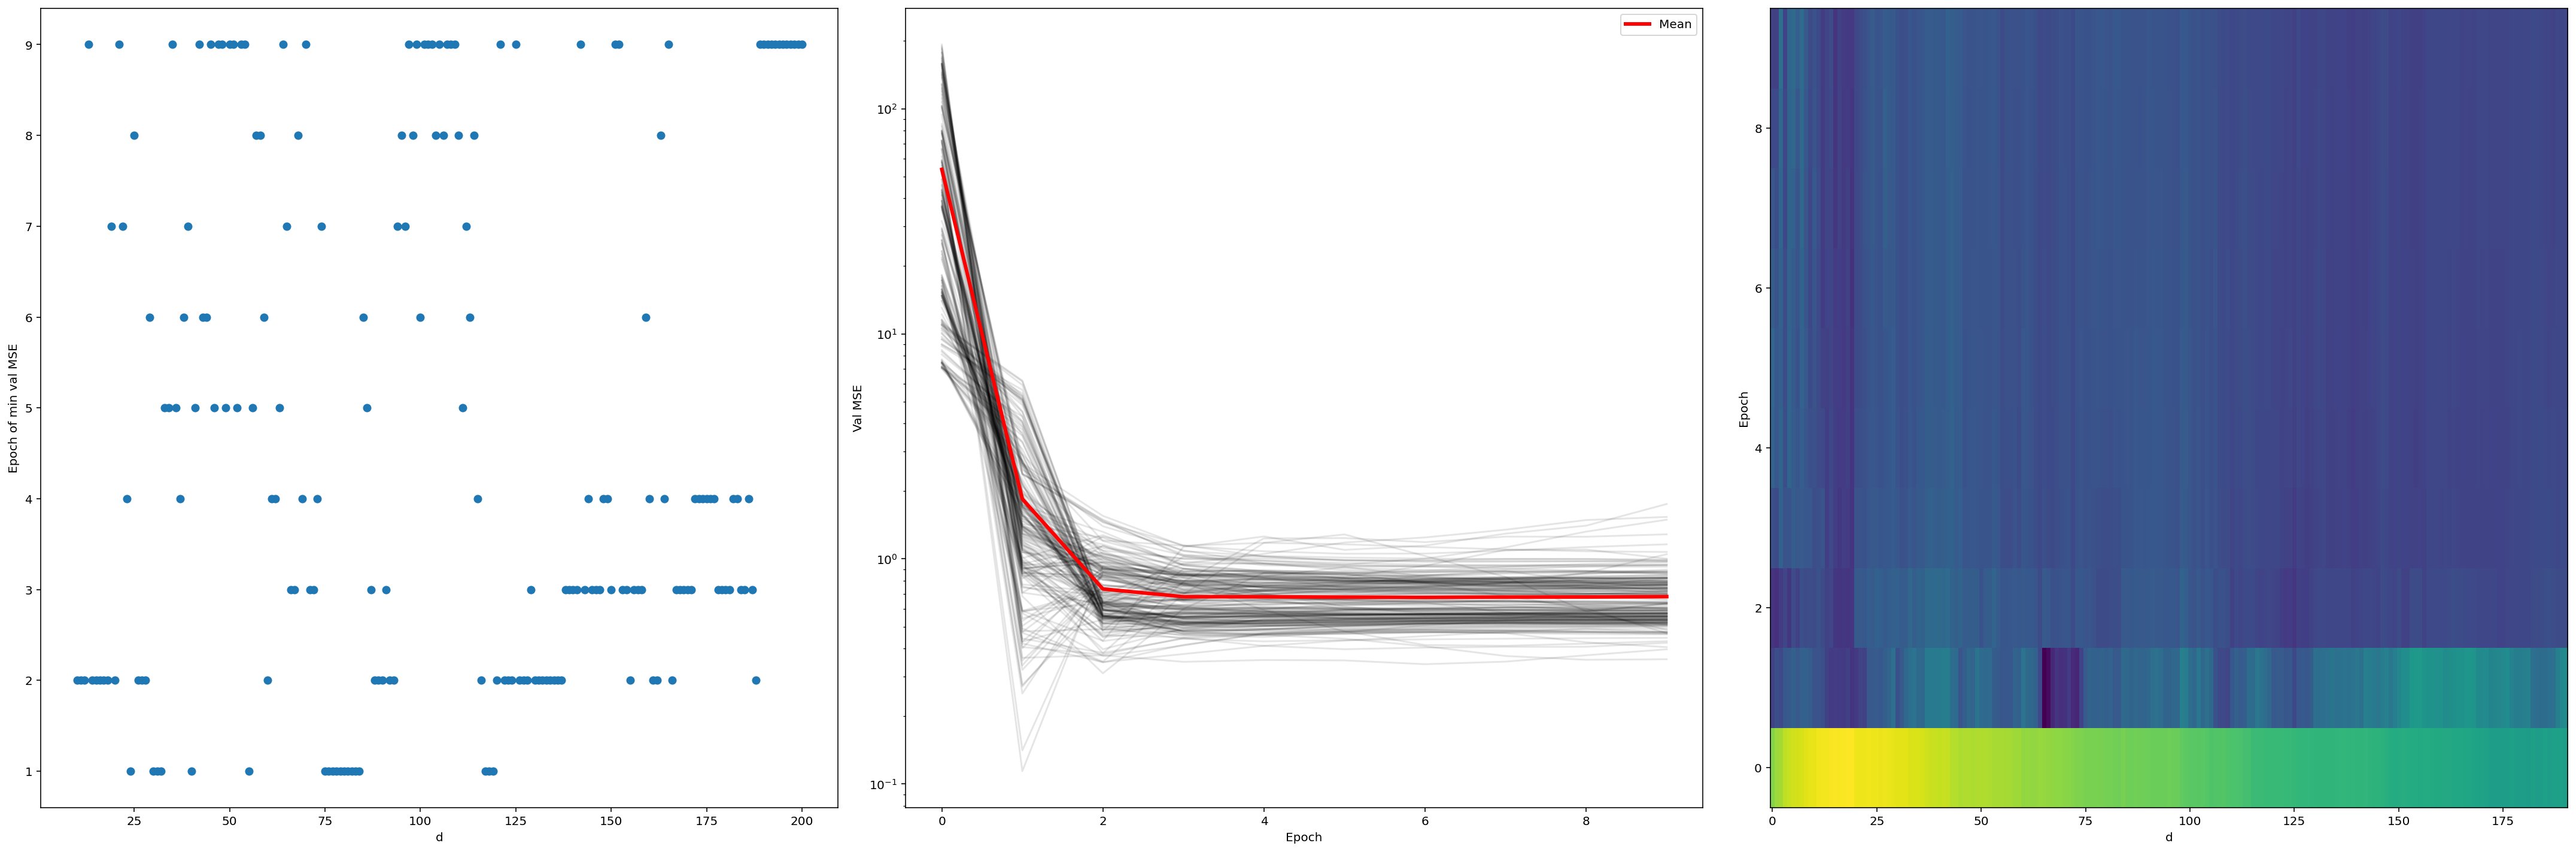

In [ ]:
fix, ax = plt.subplots(ncols=3, figsize=(30, 10))
mse_hist = np.array(mse_hist)

ax[0].scatter(d_range, mse_hist.argmin(axis=1))
ax[0].set_xlabel("d")
ax[0].set_ylabel("Epoch of min val MSE")

# on ax[1], plot each row of mse_hist
for i in range(mse_hist.shape[0]):
    ax[1].plot(mse_hist[i, :], alpha=0.1, color="black")

ax[1].plot(mse_hist.mean(axis=0), color="red", label="Mean", linewidth=3)
ax[1].set_yscale("log")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Val MSE")
ax[1].legend()

ax[2].imshow(np.log(mse_hist.T), aspect="auto", origin="lower")
ax[2].set_xlabel("d")
ax[2].set_ylabel("Epoch")

plt.tight_layout()

In [ ]:
M

array([[ 0.1282845 ,  0.12837989, -1.39490642, ..., -0.20376227,
         0.10921768,  0.04547566],
       [ 0.12837989,  0.13676173, -1.35645873, ..., -0.19794278,
         0.10810718,  0.047102  ],
       [-1.39490642, -1.35645873, 15.4258019 , ...,  2.25722694,
        -1.19748357, -0.48711874],
       ...,
       [-0.20376227, -0.19794278,  2.25722694, ...,  0.3304212 ,
        -0.17512869, -0.07112669],
       [ 0.10921768,  0.10810718, -1.19748357, ..., -0.17512869,
         0.09341051,  0.03850123],
       [ 0.04547566,  0.047102  , -0.48711874, ..., -0.07112669,
         0.03850123,  0.01642748]])

In [ ]:
# Compute the eigenvalues and eigenvectors of M
eigvals, eigvecs = np.linalg.eig(M)

# Sort the eigenvalues in decreasing order and get the corresponding indices
idx = np.argsort(eigvals)[::-1]

# Select the top 3 eigenvectors
top3_eigvecs = eigvecs[:, idx[:3]]

In [ ]:
top3_eigvecs

array([[-4.90798957e-02+0.j, -4.17127740e-02+0.j,  1.15778776e-01+0.j],
       [-4.75355884e-02+0.j, -1.20907351e-01+0.j,  5.69446421e-02+0.j],
       [ 5.43724185e-01+0.j,  5.25188997e-02+0.j,  5.19948562e-03+0.j],
       [-4.33349852e-02+0.j,  1.64071108e-02+0.j, -4.88187077e-02+0.j],
       [ 6.26788801e-02+0.j, -1.11072138e-01+0.j, -3.33644044e-02+0.j],
       [-5.13399052e-02+0.j, -8.43959542e-02+0.j,  1.54429788e-01+0.j],
       [-9.63833816e-02+0.j,  7.53560741e-02+0.j, -1.99725618e-02+0.j],
       [-1.06182105e-01+0.j,  5.94141602e-02+0.j,  1.42342623e-02+0.j],
       [ 3.14199457e-02+0.j,  9.03705194e-02+0.j,  7.38481534e-03+0.j],
       [-1.08999826e-01+0.j,  7.64296468e-03+0.j,  6.56211811e-02+0.j],
       [ 4.51642172e-02+0.j, -3.76078002e-02+0.j,  6.24113426e-02+0.j],
       [-1.07153506e-02+0.j,  9.77148064e-02+0.j,  1.36724200e-01+0.j],
       [ 1.21512274e-02+0.j,  1.11429276e-01+0.j, -7.70834972e-02+0.j],
       [ 8.40328646e-02+0.j, -4.74868489e-02+0.j, -5.02849016e-0

In [ ]:
# Normalize the eigenvectors
from numpy.linalg import norm

norm_top3_eigvecs = np.apply_along_axis(norm, axis=0, arr=top3_eigvecs)
normalized_top3_eigvecs = top3_eigvecs / norm_top3_eigvecs

# Calculate the angles between the top 3 eigenvectors
angles = np.zeros((3, 3))
for i in range(3):
    for j in range(i+1, 3):
        angles[i, j] = np.arccos(normalized_top3_eigvecs[:, i].dot(normalized_top3_eigvecs[:, j]))
        angles[j, i] = angles[i, j]  # since the angle between i and j is the same as the angle between j and i

print("Angles between the top 3 eigenvectors:")
print(angles)

Angles between the top 3 eigenvectors:
[[0.         1.57079633 1.57079633]
 [1.57079633 0.         1.57079633]
 [1.57079633 1.57079633 0.        ]]


<ipython-input-62-32c0faca7203>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[i, j] = np.arccos(normalized_top3_eigvecs[:, i].dot(normalized_top3_eigvecs[:, j]))
